<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lorenz-trajectory" data-toc-modified-id="Lorenz-trajectory-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Lorenz trajectory</a></span><ul class="toc-item"><li><span><a href="#CV-predictions" data-toc-modified-id="CV-predictions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>CV predictions</a></span></li><li><span><a href="#clustering-predictions" data-toc-modified-id="clustering-predictions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>clustering predictions</a></span></li></ul></li><li><span><a href="#t+h-predictions" data-toc-modified-id="t+h-predictions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>t+h predictions</a></span></li></ul></div>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from tqdm.auto import tqdm

import random

In [3]:
from sklearn.cluster import DBSCAN

from src.Lorentz import Lorentz
from src.TSProcessor import TSProcessor

%load_ext autoreload
%autoreload 2

In [186]:
from src.utils import normalize, denormalize, gen_sin_wave, plot_trajectories, plot_runs
from copy import deepcopy

## Lorenz trajectory

### CV predictions

In [188]:
train_size = 500
h_max = 50 # max prediction horizon (t+h)
n_folds = 50


points_in_template = 4
max_template_spread = 10 # max distance between y_t1 and y_t2, y_1 and y_11


# trajectories prediction parameters
eps = 0.01
n_trajectories = 24
noise_amp = 0.01
priori_eps = 0.2


# unified prediction parameters
dbs_eps = 0.01
dbs_min_samples = int(0.25*n_trajectories)
dbs_min_trajectories = int(0.25*n_trajectories)
# dbs_cluster_difference = int(0.25*n_trajectories)

alpha = 0.3
max_err = 0.05
min_trajectories = int(0.5*n_trajectories)

In [189]:
x, _, _ = Lorentz().generate(0.1, 3000+n_folds*(train_size+h_max)-1) # -1 because of an implementation bug
x, x_min, x_max = normalize(x[3000:]) # "For the Lorenz series, the first 3000 observations are discarded..."

In [190]:
runs = {
    'unified': {
        'rmse': np.zeros((n_folds, h_max)),
        'non_pred': np.zeros((n_folds, h_max)),
    },
    'single': {
        'rmse': np.zeros((n_folds, h_max)),
        'non_pred': np.zeros((n_folds, h_max)),
    },
    'priori': {
        'rmse': np.zeros((n_folds, h_max)),
        'non_pred': np.zeros((n_folds, h_max)),
    },
    'unified_quantile': {
        'rmse': np.zeros((n_folds, h_max)),
        'non_pred': np.zeros((n_folds, h_max)),
    },
}


for fold in tqdm(range(n_folds)):
    t = (train_size+h_max) * fold
    X_train = x[t:t+train_size]
    
    start_points = max_template_spread * (points_in_template-1)
    X_start = x[t+train_size-start_points:t+train_size]
    
    X_test = x[t+train_size:t+train_size+h_max]
    
    
    tsp = TSProcessor(
        points_in_template=points_in_template,
        max_template_spread=max_template_spread)
    tsp.fit(X_train)
    
    
    # unified
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=n_trajectories,
        noise_amp=noise_amp,
        save_first_type_non_pred=False,
        random_seed=1,
        n_jobs=-1,
        print_time=False,
    )
    
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='cluster',
        dbs_min_trajectories=dbs_min_trajectories,
        dbs_eps=dbs_eps,
        dbs_min_samples=dbs_min_samples,
    )
    X_pred = unified_result['X_pred']
    
    non_pred = np.isnan(X_pred).astype(int)
    rmse = (X_pred - X_test)**2
    runs['unified']['rmse'][fold] = rmse
    runs['unified']['non_pred'][fold] = non_pred
    
    
    # unified_quantile
    
    # reusing X_traj_pred from previoius step
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='quantile',
        alpha=alpha,
        max_err=max_err,
        min_trajectories=min_trajectories,
    )
    X_pred = unified_result['X_pred']
    
    non_pred = np.isnan(X_pred).astype(int)
    rmse = (X_pred - X_test)**2
    runs['unified_quantile']['rmse'][fold] = rmse
    runs['unified_quantile']['non_pred'][fold] = non_pred
    
    
    # priori
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=n_trajectories,
        noise_amp=noise_amp,
        use_priori=True,
        X_test=X_test,
        priori_eps=priori_eps,
        save_first_type_non_pred=True,
        random_seed=1,
        n_jobs=-1,
        print_time=False,
    )
    
    unified_result = tsp.predict_unified(
        X_traj_pred,
        method='cluster',
        use_priori=True,
        X_test=X_test,
        priori_eps=priori_eps,
        dbs_min_trajectories=dbs_min_trajectories,
        dbs_eps=dbs_eps,
        dbs_min_samples=dbs_min_samples,
    )
    X_pred = unified_result['X_pred']
    
    non_pred = np.isnan(X_pred).astype(int)
    rmse = (X_pred - X_test)**2
    runs['priori']['rmse'][fold] = rmse
    runs['priori']['non_pred'][fold] = non_pred
    
    
    # single
    X_traj_pred = tsp.predict_trajectories(
        X_start, h_max,
        eps=eps,
        n_trajectories=1,
        noise_amp=0,
        use_priori=False,
        save_first_type_non_pred=True,
        random_seed=1,
        n_jobs=-1,
        print_time=False,
    )
    X_pred = X_traj_pred[:, 0]
    
    non_pred = np.isnan(X_pred).astype(int)
    rmse = (X_pred - X_test)**2
    runs['single']['rmse'][fold] = rmse
    runs['single']['non_pred'][fold] = non_pred

  0%|          | 0/50 [00:00<?, ?it/s]

In [191]:
runs_processed = deepcopy(runs)
for method in runs_processed.keys():
    rmses = runs_processed[method]['rmse']
    non_preds = runs_processed[method]['non_pred']
    non_preds = 100*non_preds.sum(axis=0) / non_preds.shape[0]
    rmses = np.sqrt(np.nan_to_num(rmses / (rmses.shape[0] - np.isnan(rmses).sum(axis=0))).sum(axis=0))
    runs_processed[method]['rmse'] = rmses
    runs_processed[method]['non_pred'] = non_preds

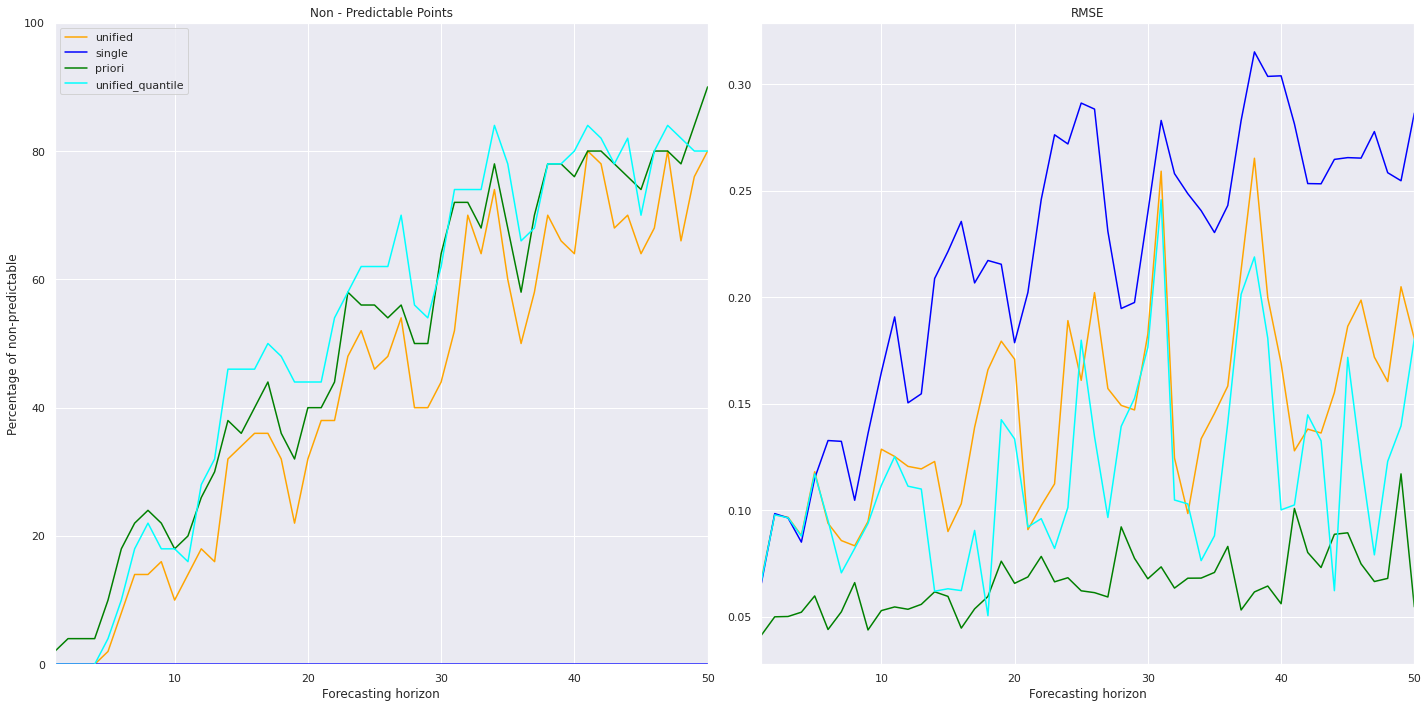

In [195]:
plot_runs(runs_processed, h_max, filename='fig4.png')

### clustering predictions

In [159]:
train_size = 500
h_max = 50 # max prediction horizon (t+h)
n_folds = 10


points_in_template = 4
max_template_spread = 10 # max distance between y_t1 and y_t2, y_1 and y_11


# trajectories prediction parameters
eps = 0.01
n_trajectories = 24
noise_amp = 0.01
priori_eps = 0.2


# unified prediction parameters
dbs_eps = 0.01
dbs_min_samples = int(0.25*n_trajectories)
dbs_min_trajectories = int(0.25*n_trajectories)
# dbs_cluster_difference = int(0.25*n_trajectories)

alpha = 0.3
max_err = 0.05
min_trajectories = int(0.5*n_trajectories)

In [154]:
x, _, _ = Lorentz().generate(0.1, 3000+n_folds*(train_size+h_max)-1) # -1 because of an implementation bug
x, x_min, x_max = normalize(x[3000:]) # "For the Lorenz series, the first 3000 observations are discarded..."

In [155]:
fold = 0
t = (train_size+h_max) * fold

X_train = x[t:t+train_size]

start_points = max_template_spread * (points_in_template-1)
X_start = x[t+train_size-start_points:t+train_size]

X_test = x[t+train_size:t+train_size+h_max]


tsp = TSProcessor(
    points_in_template=points_in_template,
    max_template_spread=max_template_spread)
tsp.fit(X_train)

# unified
X_traj_pred = tsp.predict_trajectories(
    X_start, h_max,
    eps=eps,
    n_trajectories=n_trajectories,
    noise_amp=noise_amp,
    use_priori=False,
    X_test=X_test,
    priori_eps=priori_eps,
    save_first_type_non_pred=False,
    random_seed=1,
    n_jobs=-1,
    print_time=False,
)

In [156]:
unified_result = tsp.predict_unified(
    X_traj_pred,
    method='cluster',
    dbs_min_trajectories=dbs_min_trajectories,
    dbs_eps=dbs_eps,
    dbs_min_samples=dbs_min_samples,
)
X_pred = unified_result['X_pred']
traj_alive = unified_result['traj_alive']
cluster_centers = unified_result['cluster_centers']

non_pred = np.isnan(X_pred).astype(int)
rmse = (X_pred - X_test)**2

0 [24]
1 [23]
2 [23]
3 [24]
4 [24]
5 [24]
6 [24]
7 [23]
8 [24]
9 [23]
10 [22]
11 [24]
12 [23]
13 [22]
14 [23]
15 [24]
16 [24]
17 [23]
18 [23]
19 [23]
20 [ 8 13]
21 [ 5 16]
22 [8 6 6]
23 [24]
24 [21]
25 [23]
26 [15  7]
27 [9 4]
28 []
29 [4]
30 [5 5]
31 [6]
32 [18]
33 [22]
34 [11  7  4]
35 [4 5]
36 []
37 [4]
38 [4 4]
39 [5 4]
40 [5]
41 [7 6 4]
42 [6 9 4]
43 [9]
44 [6]
45 [15  4]
46 [5 5 4]
47 [8 7]
48 [9 4]
49 [12]


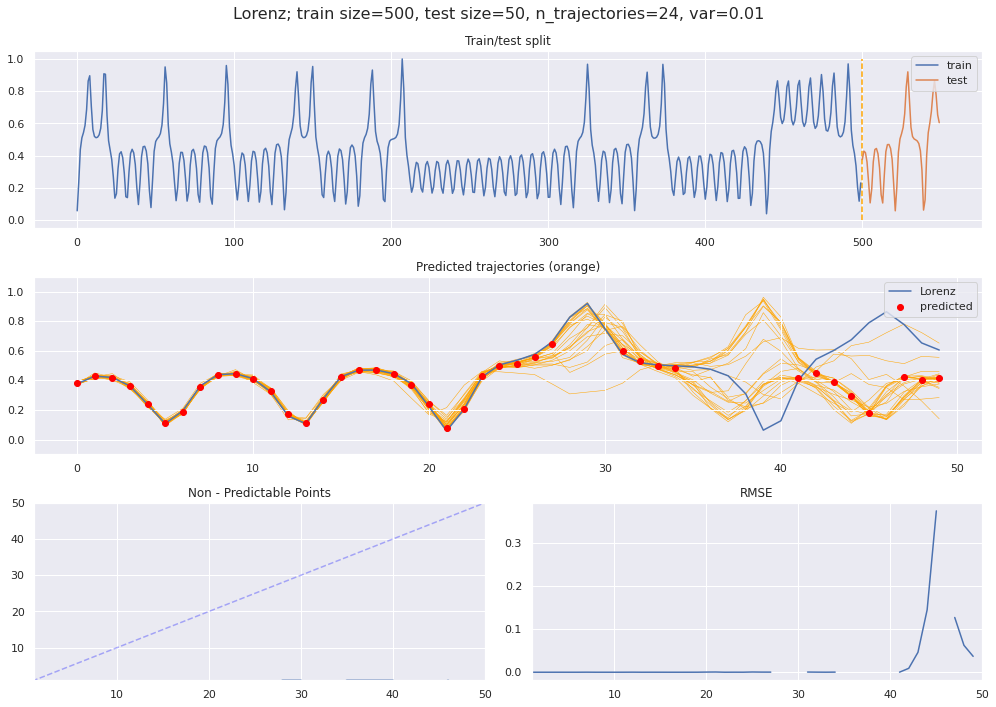

In [157]:
plot_trajectories(
    'Lorenz', X_train, X_test, # plotting since X_start
    noise_amp, n_trajectories,
    X_traj_pred, X_pred, non_pred, rmse
)

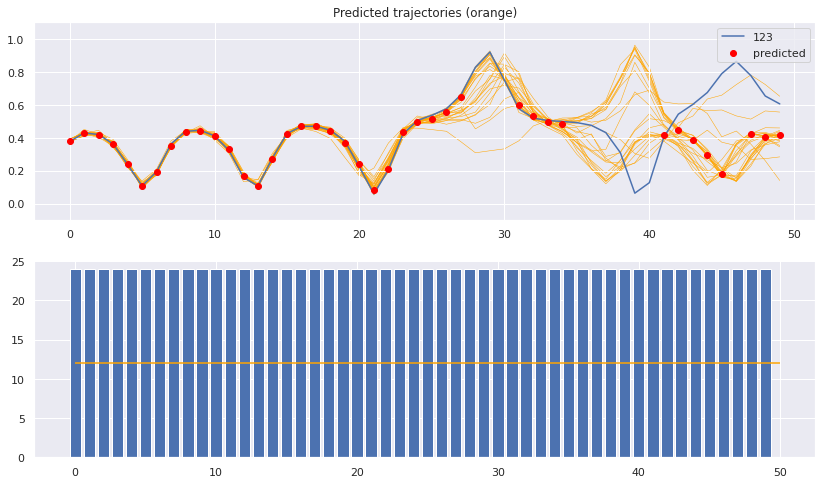

In [158]:
fig = plt.figure(figsize=[14, 8])

plt.subplot(2, 1, 1)
plt.plot(X_test, label='123', zorder=1)

plt.ylim(-0.1, 1.1)

for i in range(n_trajectories):
    plt.plot(X_traj_pred[:, i], c='orange', lw=0.5, zorder=0)

plt.scatter(range(X_pred.size),
            X_pred,
            label='predicted',
            c='red',
            zorder=2)

plt.title('Predicted trajectories (orange)')
plt.legend(loc='upper right');

plt.subplot(2, 1, 2)
plt.bar(range(len(traj_alive)), traj_alive)
plt.hlines(y=min_trajectories, xmin=0, xmax=len(traj_alive), color='orange')